# Setup

Import all necessary python libraries in this section.

In [2]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from torchgeo.datasets import NAIP, ChesapeakeDE
from torchgeo.datasets.utils import download_url, stack_samples
from torchgeo.samplers import RandomGeoSampler#, GridGeoSampler, RandomBatchGeoSampler

/home/anne/miniconda3/envs/torchgeo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [3]:
data_root = tempfile.gettempdir()
naip_root = os.path.join(data_root, "naip_train")
naip_url = (
    "https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
)
tiles = [
    "m_3807511_ne_18_060_20181104.tif",
    # "m_3807511_se_18_060_20181104.tif",
    # "m_3807512_nw_18_060_20180815.tif",
    # "m_3807512_sw_18_060_20180815.tif",
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)

100%|██████████| 513332284/513332284 [02:10<00:00, 3934774.75it/s]


Next, we tell TorchGeo to download the corresponding Chesapeake labels.

In [4]:
chesapeake_root = os.path.join(data_root, "chesapeake_train")

chesapeake = ChesapeakeDE(chesapeake_root, download=True)

100%|██████████| 287350495/287350495 [03:47<00:00, 1265457.68it/s]


# Data exploration

In [5]:
cache = True

In [6]:
chesapeake = ChesapeakeDE(chesapeake_root, cache=cache)
naip = NAIP(naip_root, crs=chesapeake.crs, res=chesapeake.res, cache=cache)

# we create an IntersectionDataset so that we can automatically sample from both
# GeoDatasets simultaneously.
dataset = chesapeake & naip

#Unlike typical PyTorch Datasets, TorchGeo GeoDatasets are indexed using 
# lat/long/time bounding boxes. This requires us to use a custom GeoSampler 
# instead of the default sampler/batch_sampler that comes with PyTorch.
# sampler = GridGeoSampler(dataset, size=1000, stride=500)
sampler = RandomGeoSampler(dataset, size=256, length=10000)

# we combine the dataset and the sampler into a dataloader
dataloader = DataLoader(
    dataset, batch_size=12, sampler=sampler, collate_fn=stack_samples
)

In [7]:
sample = next(iter(dataloader))
image = sample["image"].numpy().astype(int)
target = sample["mask"].numpy()
image.shape, target.shape

((12, 4, 256, 256), (12, 1, 256, 256))

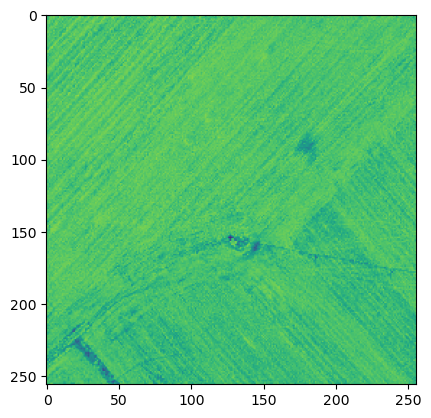

In [20]:
plt.imshow(image[10,0,:,:], vmin=0, vmax=255)

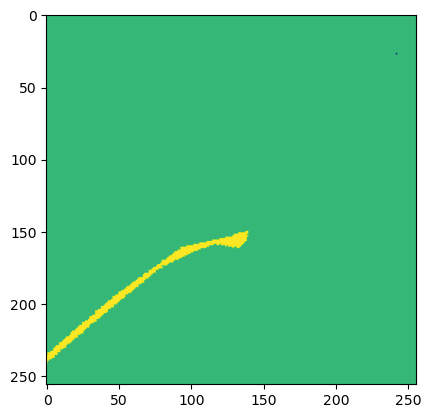

In [21]:
plt.imshow(target[10,0,:,:])

In [22]:
np.unique(target[10,0,:,:])

array([3, 5, 6])